
![main](https://www.dataquest.io/blog/content/images/2017/12/kaggle-amassachi-1.png)

### With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Practice Skills
* Creative feature engineering 
* Advanced regression techniques like random forest and gradient boosting

### Recommend : This tutorial doesn't cover EDA . If you are looking at this dataset for the first time , Visit the first part of this kernel , which takes care of the Explanatory Data Analysis.
https://www.kaggle.com/niteshx2/kernel-housing-prices-using-dummy-vars

## Step 1 : Import Statements , you can use this code as it is.

(Output Shows files already present in the Environment (By Kaggle)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from analysis_preprocess import Preprocessing
from datetime import datetime


C:\Windows\Temp\ipykernel_20872\3235352973.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


## Now , we load the required files 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
preprocesseddata = Preprocessing(train, test)

train = preprocesseddata.wrangletrain()
#val = preprocesseddata.wrangleval()
test = preprocesseddata.wrangletest()

D:\Sean\Documents\GitHub\Tabular Data\House Price Prediction\analysis_preprocess.py:252: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.data['MasVnrArea'].fillna(0, inplace=True)
D:\Sean\Documents\GitHub\Tabular Data\House Price Prediction\analysis_preprocess.py:255: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

Dropping index 948 because of this weird row
Value when BsmtExposure is NA but BsmtFinSF1 and BsmtUnfSF is not NA
BsmtFinSF1      0
BsmtUnfSF     936
Name: 948, dtype: int64
fixing column LotArea in test data to fit format int64
fixing column YearBuilt in test data to fit format int64
fixing column YearRemodAdd in test data to fit format int64
fixing column BsmtFinSF1 in test data to fit format int64
fixing column BsmtFinSF2 in test data to fit format int64
fixing column BsmtUnfSF in test data to fit format int64
fixing column TotalBsmtSF in test data to fit format int64
fixing column 1stFlrSF in test data to fit format int64
fixing column 2ndFlrSF in test data to fit format int64
fixing column LowQualFinSF in test data to fit format int64
fixing column GrLivArea in test data to fit format int64
fixing column BsmtFullBath in test data to fit format int64
fixing column BsmtHalfBath in test data to fit format int64
fixing column FullBath in test data to fit format int64
fixing column Hal

# Final Step :
# Now , we are getting started with the process of modelling

* K-Folds cross-validator

* Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).

* Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In [3]:
train['SalePrice'].describe()

count      1459.000000
mean     180913.259767
std       79469.162925
min       34900.000000
25%      129950.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [4]:
X, y = train.drop("SalePrice",axis = 1), train['SalePrice']
y = np.log1p(y)

In [5]:
# defining error functions for handy use. 
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [6]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [7]:
#Distance-based Learners
ridge = RidgeCV(alphas=alphas_alt, cv=kfolds)
lasso = LassoCV(max_iter=10000000, alphas=alphas2, random_state=42, cv=kfolds)
elasticnet = ElasticNetCV(max_iter=10000000, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio)

#Tree-based Learners
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)       
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=5000,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

## Stacking 
Stacking is an ensemble learning technique to combine multiple regression models via a meta-regressor. The StackingCVRegressor extends the standard stacking algorithm (implemented as StackingRegressor) using out-of-fold predictions to prepare the input data for the level-2 regressor.

In the standard stacking procedure, the first-level regressors are fit to the same training set that is used prepare the inputs for the second-level regressor, which may lead to overfitting. The StackingCVRegressor, however, uses the concept of out-of-fold predictions: the dataset is split into k folds, and in k successive rounds, k-1 folds are used to fit the first level regressor. In each round, the first-level regressors are then applied to the remaining 1 subset that was not used for model fitting in each iteration. The resulting predictions are then stacked and provided -- as input data -- to the second-level regressor. After the training of the StackingCVRegressor, the first-level regressors are fit to the entire dataset for optimal predicitons.


More : http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/
I encourage that you read more about stacking.

![](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor_files/stacking_cv_regressor_overview.png)


### In simple words , Stacking helps avoid fitting on the same data twice , and is effective in reducing overfitting.


In [8]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Here , we compare the various models that we just created..

In [9]:
# Using various prediction models that we just created
score = cv_rmse(elasticnet, X)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(ridge, X)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso, X)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr, X)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost, X)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm, X)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


elastic net: 0.1500 (0.0350)
 2024-01-30 01:19:15.162123
RIDGE: 0.1505 (0.0346)
 2024-01-30 01:19:31.641376
LASSO: 0.1498 (0.0346)
 2024-01-30 01:19:37.979025
gbr: 0.1370 (0.0175)
 2024-01-30 01:22:13.160296
xgboost: 0.1271 (0.0177)
 2024-01-30 01:23:59.019718
lightgbm: 0.1368 (0.0164)
 2024-01-30 01:24:12.703760


In [10]:
print('START Fit')
print("============ Fitting against original training data for each model ============")

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
                                          
print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
============ Fitting and Checking performance against original training data for each model ============
stack_gen


D:\Sean\Miniconda3\envs\datascience\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RidgeCV was fitted without feature names
  warnings.warn(
D:\Sean\Miniconda3\envs\datascience\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(
D:\Sean\Miniconda3\envs\datascience\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
D:\Sean\Miniconda3\envs\datascience\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Stacked regression: 0.0356
elasticnet
ElasticNet: 0.1270
Lasso
Lasso: 0.1267
Ridge
Ridge: 0.1270
GradientBoosting
Gradient Boosting: 0.0509
xgboost
XGBoost: 0.0406
lightgbm
LightGBM: 0.0868


# Blending Models / 'Ensambling'
* Notice that we are using a few percent from different models to get our final answer , all decimals add up to 1

In [26]:
def blend_models_predict(X):
    return ((0.05 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.05 * ridge_model_full_data.predict(X)) + \
            (0.15 * gbr_model_full_data.predict(X)) + \
            (0.2 * xgb_model_full_data.predict(X)) + \
            (0.15 * lgb_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))    


In [27]:
#xval = val.drop(columns = ['SalePrice'])
#yval = np.log1p(val['SalePrice'])
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

#Adjusting with val data
#print('RMSLE score on val data (Outliers from train data):')
#print(rmsle(yval, blend_models_predict(xval)))

RMSLE score on train data:
0.04967514487281021


### Here , we are also blending(Read: Ensambling) with the data availiable from other 'top' public Kernels .
* This helps our model generalize on unseen data pretty well

# Submission

In [28]:
print('Predict submission')
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = (np.expm1(blend_models_predict(test)))

Predict submission


In [29]:
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)
# Quantiles helping us get some extreme values for extremely low or high values 
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission.csv", index=False)

<Axes: xlabel='SalePrice', ylabel='Count'>

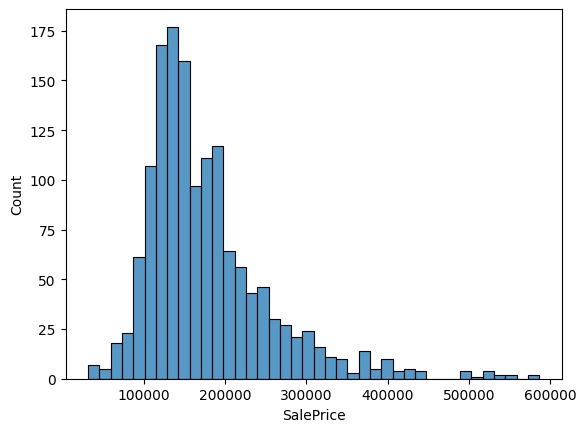

In [30]:
import seaborn as sns
sns.histplot(submission['SalePrice'])

In [31]:
submission.head()

,Id,SalePrice
0,1461,117158.210750
1,1462,154169.152278
2,1463,180502.392465
3,1464,192665.893649
4,1465,182883.603031
